In [1]:
from __future__ import division
import json
import itertools
import swifter
import operator
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('use_inf_as_na', True)
plt.style.use('seaborn-whitegrid')
%matplotlib inline

__author__ = 'HK Dambanemuya'
__version__ = 'Python 2'

'''
    Analysis originaly performed in Python 2 (deprecated)
    Seaborn, Statsmodel, and * imports broken in Python 3
'''

/Users/henrydambanemuya/Library/Python/2.7/lib/python/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Feature Dictionary
# Removed "Endorsement_Count" from borrower features
# "OnTimeProsperPayments","TotalProsperLoans"
# "LenderYieldRate", "BorrowerMaximumRate", "BidMaximumRate"

features = {"Borrower": ["BorrowerAge", "Role_Count",  "IsBorrowerHomeowner", "ProsperScore", "DebtToIncomeRatio", "CreditScoreRange"],
            "Lender": ["CV", "BidCount", "TimeToFirstBid", "TimeBetweenFirstLastBid", "LenderMedianAge"],
            "Loan": ["BorrowerRate", 'AgeInMonths', 'EstimatedLoss', 
                     "MonthlyLoanPayment", "AmountRequested", "DescriptionLength", "CreditGrade"]}

## Bid Data

In [3]:
bid_features = ["ListingKey","FirstBidCreationDate", "LastBidCreationDate", 
                "NoBids", "AmountRequested", "AvgInterBidTime", "Gini", "CV", 
                "DebtToIncomeRatio", "DescriptionLength", "RepaidOrNot"]

# Lender bids coefficient of variation
def bid_cv(bid_amount_list):
    return np.std(bid_amount_list) / np.mean(bid_amount_list)  

In [4]:
f = {'Lst_Key': ['max'],
     'CreationDate': ['min'],
     'LastBidCreationDate':['max'],
     'Amount': [bid_cv]
}
# Bid Feature Engineering from Bid Level Data
bid_fe = pd.read_csv("../Data/bid_notick.txt", sep="|")
bid_fe['Lst_Key'] = bid_fe.ListingKey # Duplicate Listing Key Column for Grouping
bid_fe['LastBidCreationDate'] = bid_fe.CreationDate
bid_fe = pd.DataFrame(bid_fe[['ListingKey','Lst_Key', 'CreationDate', 'LastBidCreationDate', 'Amount']].groupby('ListingKey').agg(f).as_matrix())
bid_fe = bid_fe.rename(index=str, columns={0: "LastBidCreationDate", 
                                           1: "CV",
                                           2: "FirstBidCreationDate",
                                           3: "ListingKey"})
bid_fe.head(5)

,LastBidCreationDate,CV,FirstBidCreationDate,ListingKey
0,2007-03-27 06:00:56,0.000,2007-03-26 21:32:13,00003383856420083050622
1,2007-12-06 21:56:15,0.000,2007-12-06 21:56:15,00003405662222292C12B86
2,2007-12-23 08:24:07,0.000,2007-12-23 08:24:07,000034085359462718B9059
3,2008-05-17 12:11:41,0.333,2008-05-17 12:01:44,000034203787284229CBEF1
4,2008-06-25 19:29:08,0.958,2008-06-18 19:53:23,00003423466422120D65CA3


In [5]:
# Listing Level Bid Data
bid_data = pd.read_csv("../Data/ProjectLevelData.txt", sep="|")
# Filter Funded (Repaid and Defaulted) Listings
bid_data = bid_data.query("RepaidOrNot==True or RepaidOrNot==False")
# Merge Listing Level Bid Data with Engineered Bid Features at Listing Level
bid_data = bid_data.merge(bid_fe, on="ListingKey", how="inner")
# Filter Bid Features
bid_data = bid_data[bid_features]
# Delete Bid Feature Engineering Dataset
del bid_fe
# Debt to Income Ratio Median
dtirm = bid_data.DebtToIncomeRatio.median()
bid_data['DebtToIncomeRatio'] = bid_data['DebtToIncomeRatio'].fillna(dtirm)
# Show sample data
bid_data.sample(5)

,ListingKey,FirstBidCreationDate,LastBidCreationDate,NoBids,AmountRequested,AvgInterBidTime,Gini,CV,DebtToIncomeRatio,DescriptionLength,RepaidOrNot
27566,CFE6338387327317507B982,2007-03-10 17:29:13,2007-03-14 21:13:35,12,1000.000,30021.917,0.426,1.167,0.380,111,False
4576,22D43421804482501ED579B,2008-05-22 12:10:06,2008-05-29 12:09:32,196,9000.000,3077.296,0.444,2.175,0.100,86,True
4618,232E3399321524778F75863,2007-08-29 06:15:07,2007-08-30 22:08:52,189,18000.000,736.995,0.346,0.846,0.130,385,False
16609,7C863411234888872394115,2008-01-12 14:49:32,2008-01-15 00:05:18,77,2700.000,2266.403,0.238,0.904,0.080,349,True
512,03D13427698396729470DED,2008-08-11 08:57:59,2008-08-18 04:18:04,155,5000.000,3828.542,0.325,0.912,0.730,435,True


## Member Data

In [6]:
def count_endorsements(input_string):
    result = 0
    for i in range(1, len(input_string)-1):
        if input_string[i-1:i+8] == 'MemberKey':
            result += 1
    return result/2

In [7]:
member_data = pd.read_csv('../Data/member.txt', sep="|", converters={'FriendMemberKeys': lambda x: x[1:-1].split(','),
                                                                     'Roles': lambda x: x[1:-1].split(',')})
member_data['Friend_Count'] = member_data.FriendMemberKeys.apply(len)
member_data['Endorsement_Count'] = member_data.Endorsements.map(str).apply(count_endorsements).astype(int)
member_data['Role_Count'] = member_data.Roles.swifter.apply(len)
member_data['Group_Count'] = member_data.SupportedGroupKeys.map(str).apply(len)
member_data['Watching'] = member_data.WatchListingKeys.map(str).apply(len)
member_data = member_data[["Mem_Key", "Friend_Count", "Endorsement_Count", "Role_Count", "Group_Count", "Watching", "CreationDate"]]
member_data = member_data.rename(index=str, columns={"Mem_Key": "MemberKey", "CreationDate": "MemberCreationDate"})
member_data = member_data.fillna(0)
member_data.head(10)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdQYW5kYXMgQXBwbHknLCBtYXg9MTM0MDAyNiwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl/igKY=


,MemberKey,Friend_Count,Endorsement_Count,Role_Count,Group_Count,Watching,MemberCreationDate
0,19F03365539649838297324,14,3,3,3,3,2005-10-31 00:16:00
1,69FF3364999125356EF09CB,1,0,1,3,3,2005-10-31 00:16:00
2,F4273365023760472DBD934,6,0,4,47,3,2005-10-31 00:17:00
3,754933652214816673645F0,5,1,4,23,3,2005-10-31 00:18:00
4,7BFA33650989773378C52A6,1,0,1,3,3,2005-10-31 00:19:00
5,033E336453973913915CD6B,2,0,2,23,3,2005-10-31 00:19:00
6,0C6833654135154793C05F3,4,0,2,3,3,2005-10-31 00:27:00
7,E7EF3365767882092C551BE,3,0,2,3,3,2005-10-31 00:31:00
8,555C336612388076575E710,24,11,3,3,2447,2005-10-31 09:10:00
9,90733364477414531B52EDA,3,0,4,623,2735,2005-10-31 10:44:00


## Listing Data

In [8]:
def count_images(input_string):
    result = 0
    for i in range(1, len(input_string)-1):
        if input_string[i-1:i+4] == 'Value':
            result += 1
    return result/2

funding_mapping = {"Open For Duration": 0, "Close When Funded": 1}

In [9]:
listing_data = pd.read_csv('../Data/listing.txt', sep="|")
listing_data = listing_data[["Lst_Key", "CreationDate", "StartDate", "MemberKey", "Category", "BidMaximumRate", "BidCount", 
                             "ProsperPrincipalBorrowed", "ProsperPrincipalOutstanding", "Duration", "Images",
                             "IsBorrowerHomeowner", "ActiveProsperLoans",  "BorrowerRate", "BorrowerMaximumRate",  
                             "TotalProsperLoans",  "ProsperScore", "GroupLeaderRewardRate", "EffectiveYield", "FundingOption",
                             "EstimatedReturn", "EstimatedLoss", "LenderRate", "LenderYield",  "MonthlyLoanPayment",
                             "OnTimeProsperPayments", "ProsperPaymentsLessThanOneMonthLate", "ProsperPaymentsOneMonthPlusLate", 
                             "TotalProsperPaymentsBilled", "CreditScoreRangeLower", "CreditScoreRangeUpper", "BankDraftFeeAnnualRate"]]
# Create CreditScoreRange Feature and impute missing data
listing_data["CreditScoreRange"] = listing_data.CreditScoreRangeUpper - listing_data.CreditScoreRangeLower
listing_data["CreditScoreRange"] = listing_data.CreditScoreRange.fillna(np.median(listing_data.CreditScoreRange))
# Impute 0 for missing values
zero_na = ['ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'ActiveProsperLoans', "TotalProsperLoans",
          'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'TotalProsperPaymentsBilled']
for attr in zero_na:
    listing_data[attr] = listing_data[attr].fillna(0)
# Impute -1 for missing values
neg1_na = ["IsBorrowerHomeowner", "ProsperScore", ]
for attr in neg1_na:
    listing_data[attr] = listing_data[attr].fillna(-1)
# Estimated Loss
elm = listing_data.EstimatedLoss.median()
listing_data["EstimatedLoss"] = listing_data["EstimatedLoss"].fillna(elm)
# Estimated Return 
erm = listing_data.EstimatedReturn.median()
listing_data["EstimatedReturn"] = listing_data["EstimatedReturn"].fillna(erm)
# Effective Yield
eym = listing_data.EffectiveYield.median()
listing_data["EffectiveYield"] = listing_data["EffectiveYield"].fillna(erm)
# On Time Prosper Payments
otpp = listing_data.OnTimeProsperPayments .median()
listing_data["OnTimeProsperPayments"] = listing_data["OnTimeProsperPayments"].fillna(erm)
# Images Feature
listing_data["NumImages"] = listing_data.Images.map(str).apply(count_images).astype(int)
# Funding Feature
listing_data["FundingOption"] = listing_data.FundingOption.map(funding_mapping)
# Combine Lender Yield and Rate
listing_data["LenderYieldRate"] = listing_data.LenderYield + listing_data.LenderRate
listing_data = listing_data.drop(["LenderYield", "LenderRate", 'CreditScoreRangeLower', 'CreditScoreRangeUpper'], axis=1)
# Rename Listing Key Column
listing_data = listing_data.rename(index=str, columns={"Lst_Key": "ListingKey", "CreationDate": "ListingCreationDate", "StartDate": "ListingStartDate"})
# Show sample data
listing_data.sample(5)

,ListingKey,ListingCreationDate,ListingStartDate,MemberKey,Category,BidMaximumRate,BidCount,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,Duration,...,EstimatedLoss,MonthlyLoanPayment,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,TotalProsperPaymentsBilled,BankDraftFeeAnnualRate,CreditScoreRange,NumImages,LenderYieldRate
102421,8F5F33908883919996170F4,2007-06-06 05:34:25,2007-06-08 14:05:16,776C33908570520802E90D6,0,0.160,3,0.000,0.000,7,...,0.119,474.620,0.125,0.000,0.000,0.000,0.000,nan,3,0.310
117298,BB4E3389521041169CE27C0,2007-05-14 14:58:19,2007-05-14 14:58:19,41FA3389102539698F49816,0,0.100,0,0.000,0.000,10,...,0.119,806.680,0.125,0.000,0.000,0.000,0.000,20.000,0,0.190
212790,8BAF3407746119432EEC129,2007-12-10 20:48:16,2007-12-19 09:38:44,9DFC3405263547627DAF67D,1,0.155,0,0.000,0.000,7,...,0.119,104.630,0.125,0.000,0.000,0.000,0.000,20.000,5,0.301
20511,DBD73377893107129C647A7,2007-01-13 03:03:06,2007-01-13 05:38:07,E2963372496997517B4CA69,0,0.280,6,0.000,0.000,10,...,0.119,297.820,0.125,0.000,0.000,0.000,0.000,nan,0,0.555
404918,9E34352539169774796AEF1,2011-09-06 08:57:29,2011-09-06 17:00:11,56583524798593617661BBA,1,0.319,1,0.000,0.000,14,...,0.147,304.840,0.125,0.000,0.000,0.000,0.000,20.000,0,0.630


## Borrower Feature Engineering

In [10]:
# Import Borrower Feature Engineering Data
borrower_fe = pd.read_csv("../Data/borrower_listing_attr.csv")
features["Borrower"] = features.get("Borrower") + list(set(borrower_fe.columns) - set(["ListingKey"]))
borrower_fe.head()

IOError: [Errno 2] File ../Data/borrower_listing_attr.csv does not exist: '../Data/borrower_listing_attr.csv'

## Lender Feature Engineering

In [11]:
# Import Lender Feature Engineering Data
lender_bid_fe = pd.read_csv("../Data/lender_bid_attr.csv") 
lender_bidamount_fe = pd.read_csv("../Data/lender_bidamount_attr.csv")
lender_listing_fe = pd.read_csv("../Data/lender_listing_attr.csv")
lender_herding_fe = pd.read_csv("../Data/prosper_lender_herding_dynamics.csv")
lender_age = pd.read_csv("../Data/lender_age.csv")
# Add Lender Bid Features
# features["Lender"] = features.get("Lender") + list(set(lender_bid_fe.columns) - set(["ListingKey"]))
# Add Lender BidAmount Features
# features["Lender"] = features.get("Lender") + list(set(lender_bidamount_fe.columns) - set(["ListingKey"]))
# Add Lender Listing Features
# features["Lender"] = features.get("Lender") + list(set(lender_listing_fe.columns) - set(["ListingKey"]))
# Merge Lender Dataframes
lender_fe = lender_bid_fe.merge(lender_bidamount_fe, on="ListingKey")
lender_fe = lender_fe.merge(lender_listing_fe, on="ListingKey")
lender_fe = lender_fe.merge(lender_herding_fe, on="ListingKey")
lender_fe = lender_fe.merge(lender_age, on="ListingKey", how="left")
lender_fe["LenderExperience"] = (lender_fe.LenderAvgBidWinningRate*1) + (lender_fe.LenderAvgListingSuccessRate*1.19) + (lender_fe.LenderAvgRepaymentSuccessRate*0.135)
# lender_fe["LenderMinOverMaxBidAmount"] = (lender_fe.LenderMeanBidAmount / lender_fe.LenderMaxBidAmount).fillna(0)
features["Lender"] = features.get("Lender") + ["LenderExperience"] + list(set(lender_herding_fe.columns) - set(["ListingKey", "MeanLenderBidAmount", "Herding2Coefficient", "Herding3Coefficient"]))
# Data integrity check
print len(lender_bid_fe), len(lender_bidamount_fe), len(lender_listing_fe), len(lender_age), len(lender_fe)
lender_fe.head()

IOError: [Errno 2] File ../Data/lender_bid_attr.csv does not exist: '../Data/lender_bid_attr.csv'

## Loan Data

In [12]:
loan_data = pd.read_csv('../Data/loan.txt', sep="|")
print len(loan_data)
loan_data = loan_data[["ListingKey", "AgeInMonths", "Term", "CreditGrade", "ProsperRating"]]
loan_data['ProsperRating'] = loan_data.ProsperRating.fillna(0)
creditmap = {'AA':8, 'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'HR':2, 'NC':1}
loan_data['CreditGrade'] = loan_data.CreditGrade.fillna(9)
loan_data = loan_data.applymap(lambda s: creditmap.get(s) if s in creditmap else s)
loan_data = loan_data[loan_data['CreditGrade']<9] # Drop records with no credit information
print len(loan_data)
loan_data.sample(10)

51700
29017


,ListingKey,AgeInMonths,Term,CreditGrade,ProsperRating
4980,CB4A337312025097087A519,63,36,2,0
14585,55013398401123541B2769A,54,36,4,0
17116,A96E3407491659856A7828F,51,36,2,0
27975,261A3430564491769260976,42,36,5,0
24803,72773423595865789775924,45,36,8,0
9233,08F333837879584261BEA72,60,36,4,0
18442,CA2D34112773686036226DE,50,36,2,0
10700,954F3388257741560731F32,58,36,8,0
427,40703364647359199E6B837,71,36,3,0
20624,0CBD3415291328158EF231B,48,36,8,0


## Merge Data

In [12]:
# Merge DataFrames
data = bid_data.merge(listing_data, on="ListingKey", how="inner")
data = data.merge(lender_fe, on="ListingKey", how="inner")
data = data.merge(borrower_fe, on="ListingKey", how="inner")
data = data.merge(loan_data, on="ListingKey", how="inner")
data = data.merge(member_data, on="MemberKey", how="inner")
# Convert Loan Repayment to Integer
data['RepaidOrNot'] = data['RepaidOrNot'].astype(int)
# Convert Date Columns to Datetimes
data['FirstBidCreationDate'] = pd.to_datetime(data.FirstBidCreationDate)
data['LastBidCreationDate'] = pd.to_datetime(data.LastBidCreationDate)
data['ListingCreationDate'] = pd.to_datetime(data.ListingCreationDate)
data['MemberCreationDate'] = pd.to_datetime(data.MemberCreationDate)
# Computer Time to First Bid
data['TimeToFirstBid'] = (data.FirstBidCreationDate - data.ListingCreationDate).dt.seconds / 60 # dt.minutes
# Compute Time between First and Last Bid
data['TimeBetweenFirstLastBid'] = (data.LastBidCreationDate - data.FirstBidCreationDate).dt.seconds / 60 # dt.minutes
# Compute Borrower Age
data['BorrowerAge'] = (data.ListingCreationDate - data.MemberCreationDate).dt.days
# Convert all features to numeric
features["All"] = list(itertools.chain.from_iterable(features.values()))
# Coerce all features to numeric
data[features.get("All")] = data[features.get("All")].apply(pd.to_numeric, errors='coerce')
# Print Summary Statistics
print "Listings: ", len(listing_data)
print "Funded: ", len(bid_data)
print "Loans (Paid/Defaulted): ", len(loan_data)
print "Dataset: ", len(data)
data.sample(5)

NameError: name 'lender_fe' is not defined

Listings:  415157 

Funded:  33966 

Loans (Paid/Defaulted):  51700 

Dataset:  33969

## Summary Statistics

In [14]:
data.describe()

,NoBids,AmountRequested,AvgInterBidTime,Gini,CV,DebtToIncomeRatio,DescriptionLength,RepaidOrNot,Category,BidMaximumRate,...,CreditGrade,ProsperRating,Friend_Count,Endorsement_Count,Role_Count,Group_Count,Watching,TimeToFirstBid,TimeBetweenFirstLastBid,BorrowerAge
count,28935.000,28935.000,28935.000,28935.000,28935.000,28935.000,28935.000,28935.000,28935.000,28935.000,...,28935.000,28935.000,28935.000,28935.000,28935.000,28935.000,28935.000,28935.000,28935.000,28935.000
mean,136.471,6170.963,13605.413,0.339,1.061,0.318,224.299,0.632,1.195,0.181,...,4.956,0.000,1.266,0.414,1.437,6.852,11.438,201.713,1058.590,89.902
std,142.361,5584.859,98951.340,0.130,0.647,0.913,148.368,0.482,1.916,0.074,...,1.871,0.000,1.367,0.954,0.628,42.034,152.354,357.698,486.761,158.059
min,1.000,1000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,0.000,1.000,0.000,1.000,3.000,3.000,0.000,0.000,0.000
25%,38.000,2500.000,2226.445,0.254,0.687,0.120,112.000,0.000,0.000,0.124,...,4.000,0.000,1.000,0.000,1.000,3.000,3.000,4.850,704.508,2.000
50%,89.000,4500.000,4550.511,0.332,0.914,0.190,185.000,1.000,0.000,0.170,...,5.000,0.000,1.000,0.000,1.000,3.000,3.000,15.150,1363.383,17.000
75%,184.000,8000.000,9867.125,0.409,1.221,0.300,306.000,1.000,1.000,0.230,...,6.000,0.000,1.000,1.000,2.000,3.000,3.000,210.300,1435.317,89.000
max,1206.000,25000.000,11034125.000,0.895,7.407,10.010,813.000,1.000,7.000,0.497,...,8.000,0.000,116.000,40.000,4.000,2519.000,3999.000,1439.617,1439.967,949.000


In [15]:
print ("Dataset dimension: {0}".format(data[features.get("All")].shape))
print ("\nDataset contains {0} features: {1}.".format(len(data[features.get("All")].columns), 
                                                      data[features.get("All")].columns))
print ("\nRepayment Status:")
print Counter(data['RepaidOrNot'])
print ("\nPercentage Repaid:")
print (dict(Counter(dict(Counter(data['RepaidOrNot'])))))[True] / len(data) * 100
# Save features to file
with open("../Data/features.txt", "w") as file_1:
    file_1.write(json.dumps(features))
listing_keys = dict()
listing_keys["Values"] = list(set(data.ListingKey))
with open("../Data/listing_keys.txt", "w") as file_2:
    file_2.write(json.dumps(listing_keys))
# Save final data to file
data.to_csv("../Data/prosper_final.csv", index=False)

Dataset dimension: (28935, 23)

Dataset contains 23 features: Index([u'CV', u'BidCount', u'TimeToFirstBid', u'TimeBetweenFirstLastBid',
       u'LenderMedianAge', u'LenderExperience',
       u'MeanLenderBidAmountPerSecond', u'Herding1Coefficient',
       u'MaxLenderBidAmount', u'BorrowerRate', u'AgeInMonths',
       u'EstimatedLoss', u'MonthlyLoanPayment', u'AmountRequested',
       u'DescriptionLength', u'CreditGrade', u'BorrowerAge', u'Role_Count',
       u'IsBorrowerHomeowner', u'ProsperScore', u'DebtToIncomeRatio',
       u'CreditScoreRange', u'BorrowerExperience'],
      dtype='object').

Repayment Status:
Counter({1: 18279, 0: 10656})

Percentage Repaid:
63.1726283048


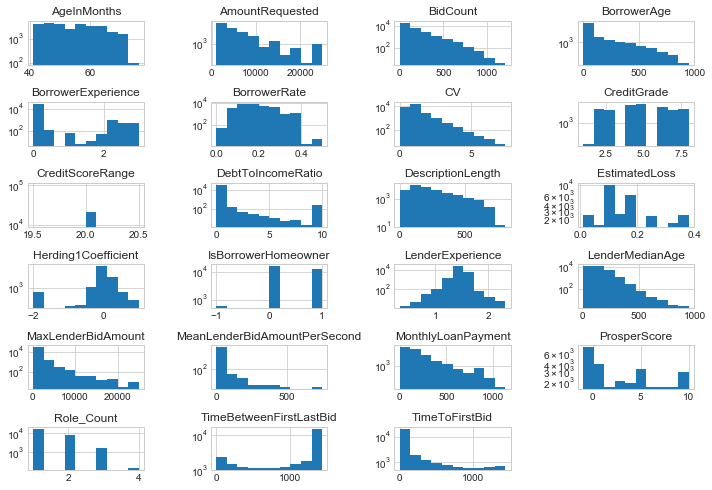

In [16]:
data[features.get("All")].hist(figsize=(10,18), layout=(16,4), log=True)
plt.grid()
plt.tight_layout()
plt.show()